In [1]:
from sirf.Gadgetron import AcquisitionData, CoilSensitivityData, AcquisitionModel, ImageData
from sirf.Utilities import assert_validity

In [2]:
def get_test_img():

    filepath_y = "/home/jovyan/InputData/y_4.h5"
    y = AcquisitionData(filepath_y)
    u = ImageData()
    u.from_acquisition_data(y)


    csm = CoilSensitivityData()
    csm.calculate(y)

    A = AcquisitionModel(acqs=y, imgs=u)
    A.set_coil_sensitivity_maps(csm)

    u_test = A.backward(y)

    return u_test

In [3]:
import numpy as np
def np_diff(arr: np.array, axis: int):
    return np.diff(
        arr, 
        axis=axis, 
        prepend=np.expand_dims(np.take(arr, 0, axis=axis), axis=axis)
    )



# class Tv():
#     """
#     Class Tv
    
#     Finite difference transformation of input image along arbitrary dimensions.
#    """
#     def __init__(self, axis):
#         # Check axis
#         if type(axis) is not list and type(axis) is not tuple:
#            raise KeyError('Axis has to be list or tuple') 
#         if any(x > 5 for x in axis):
#            raise KeyError('Axis has to be <= 5') 
#         self.axis = axis
        
        
#     def grad(self, u):
#         gu = np.zeros(u.shape + (len(self.axis),), dtype=u.dtype)
#         for ind, idx in enumerate(self.axis):
#             gu[...,ind] = self.grad_axis(u, idx)
#         return(gu)
        
        
#     def adj_grad(self, v):
#         gv = 0
#         for ind, idx in enumerate(self.axis):
#             gv += self.adj_grad_axis(v[...,ind], idx)
#         return(gv)
        

class Gradient1D:
    
    def __init__(self, axis):
        self.axis = axis

    def forward(self, u ):
        assert_validity(u, ImageData)
        u = u.copy().fill(np.roll(u.as_array(), -1, axis=self.axis) - u.as_array())
        
        return u

    def backward(self, u ):
        assert_validity(u, ImageData)
        u = u.copy().fill(np.roll(u.as_array(), 1, axis=self.axis) - u.as_array())
        
        return u    

Started reading acquisitions from /home/jovyan/InputData/y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from /home/jovyan/InputData/y_4.h5


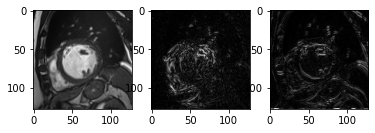

True

In [4]:
import matplotlib.pyplot as plt
def test_Gradient1D():
#     weights = ImageData()
# weights.from_acquisition_data(y)
# weights.fill(1.0)

    u = get_test_img()
    
    Gx = Gradient1D(axis=0)
    Gy = Gradient1D(axis=1)

    dxu = Gx.forward(u)
    dyu = Gy.forward(u)

    f,ax = plt.subplots(1,3)
    ax[0].imshow( np.abs(u.as_array()[0,:,:]),cmap='gray' ) 
    ax[1].imshow( np.abs(dxu.as_array()[0,:,:]),cmap='gray' ) 
    ax[2].imshow( np.abs(dyu.as_array()[0,:,:]),cmap='gray' )
    plt.show()
    
    return True

test_Gradient1D()

In [38]:

def test_image_operator_adjointness(operator, tol=1e-2):
    
    u = get_test_img()
    u = u.fill(np.random.randn(*u.shape))
    
    Ou = operator.forward(u)
    
    b = Ou.copy()
    b.fill(np.random.randn(*Ou.shape).astype(np.complex64))
    
    OHb = operator.backward(b) 
    
    Ou_b = np.vdot( Ou.as_array(), b.as_array())
    u_OHb = np.vdot( u.as_array(), OHb.as_array())
    
    print(Ou_b - u_OHb)
    
    return np.abs(Ou_b - u_OHb) < tol
    
Gx = Gradient1D(axis=0)
Gy = Gradient1D(axis=1)
Gt = Gradient1D(axis=2)
    
print(test_image_operator_adjointness(Gx))
print(test_image_operator_adjointness(Gy))
print(test_image_operator_adjointness(Gt))
    

Started reading acquisitions from /home/jovyan/InputData/y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from /home/jovyan/InputData/y_4.h5
(-0.00024414062+0j)
True
Started reading acquisitions from /home/jovyan/InputData/y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from /home/jovyan/InputData/y_4.h5
(0.0009765625+0j)
True
Started reading acquisitions from /home/jovyan/InputData/y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from /home/jovyan/InputData/y_4.h5
(0.0010375977+0j)
True


In [42]:
class Dx():
    def __init__(self):
        self.Gx = Gradient1D(axis=0)
        self.Gy = Gradient1D(axis=1)
        
    def forward(self, u):
        
        dx = self.Gx.forward(u)
        dy = self.Gy.forward(u)
        
        return (dx,dy)
    
    def backward(self, u):
        
        rv = self.Gx.backward(u[0])
        rv += self.Gy.backward(u[1])
    
        return rv
    
class Dt():

    def __init__(self):
        self.Gt = Gradient1D(axis=2)

    def forward(self, u):
        return self.Gt.forward(u)
    def backward(self, u):
        return self.Gt.backward(u)

In [43]:
def test_stacked_image_operator_adjointness(operator, tol=1e-2):
    
    u = get_test_img()
    u = u.fill(np.random.randn(*u.shape))
    
    Ou = operator.forward(u)
    
    b0 = Ou[0].fill(np.random.randn(*u.shape))
    b1 = Ou[1].fill(np.random.randn(*u.shape))
    b = (b0,b1)
        
    OHb = operator.backward(b) 
    u_OHb = np.vdot( u.as_array(), OHb.as_array())
    
    Ou =  np.stack((Ou[0].as_array()[:], Ou[1].as_array()[:]), axis=0)
    b = np.stack((b[0].as_array()[:], b[1].as_array()[:]), axis=0)
    Ou_b = np.vdot( Ou, b)
    
    
    print(Ou_b - u_OHb)
    
    return np.abs(Ou_b - u_OHb) < tol

In [44]:
nabla = Dx()
dt = Dt()
print(test_stacked_image_operator_adjointness(nabla))
print(test_image_operator_adjointness(dt))


Started reading acquisitions from /home/jovyan/InputData/y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from /home/jovyan/InputData/y_4.h5
<class 'sirf.Gadgetron.ImageData'>
(391332.25+0j)
False
Started reading acquisitions from /home/jovyan/InputData/y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from /home/jovyan/InputData/y_4.h5
(-0.00044250488+0j)
True
